<center> In the name of God <center>

# <center> Sharif University of Technology <center> Department of Economics <center>
# <center> Quantitative Economics - Spring 2022 <center>Problem Set 11<center>

##  <center> Team Members <center>
<center> - Niloofar Moradi <center>- Mohamad R. Manzaritavakoli <center>

# 1 Bellman Equation with Shocks

In [1]:
using Pkg

In [2]:

Pkg.add("Random")
Pkg.add("Interpolations")
Pkg.add("Distributions")

Pkg.add("Zygote")
Pkg.add("Flux")
Pkg.add("Optim")


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
    Updating `~/.julia/environments/v1.7/Project.toml`
  [9a3f8284] + Random
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
   Installed WoodburyMatrices ─ v0.5.5
   Installed AxisAlgorithms ─── v1.0.1
   Installed Interpolations ─── v0.13.6
    Updating `~/.julia/environments/v1.7/Project.toml`
  [a98d9a8b] + Interpolations v0.13.6
    Updating `~/.julia/environments/v1.7/Manifest.toml`
  [13072b0f] + AxisAlgorithms v1.0.1
  [a98d9a8b] + Interpolations v0.13.6
  [6fe1bfb0] + OffsetArrays v1.12.2
  [c84ed2f1] + Ratios v0.4.3
  [efce3f68] + WoodburyMatrices v0.5.5
Precompiling project...
  ✓ WoodburyMatrices
  ✓ OffsetArrays
  ✓ Ratios
  ✓ AxisAlgorithms
  ✓ Interpolations
  5 dependencies successfully precompiled in 13 seconds (157 already precompiled)
   Resolving package versions...
    Updating `~/.julia/environments/v1.7/Project.toml`
  [31c24e10

In [ ]:
using Plots
using BlackBoxOptim
using GLM
using StatsPlots
using StatsBase
using ForwardDiff
using Roots
using Interpolations
using Optim
using Random
using Distributions
using Zygote
using Flux

In [3]:
using Plots
using Interpolations
using Optim
using Random
using Zygote
using Distributions

In [19]:
Plots.theme(:juno)

In [4]:
σ = 0.1
α = 0.65
ω = 0.5
β = 0.95
N = 100
ϵ= 10^(-2);

In [5]:
Random.seed!(1394)
ζ=exp.(rand(Normal(0,ω),N));
A=mean(ζ);

## 1 Value function iteration

$$
\begin{gathered}
V(y)=\max _{c}\left\{U(c)+\beta E\left[V\left(\xi(y-c)^{\alpha}\right)\right]\right\} \\
U(c)=\frac{c^{1-\sigma}}{1-\sigma} \\
\log \xi^{\sim} N(0, \omega)
\end{gathered}
$$


We assume thete is no shock in order to calculate parameters at steady state:

The problem is:
$$
W=Max\sum_{t=0}^{\infty} \beta^{t} u\left(c_{t}\right)
$$

Subject to: $$C_{t}+I_t =A_t F(K_t)$$
$$ K_{t+1}=I_t$$

Lagrangian:
$$\mathcal{L}=\sum_{t=0}^{\infty} \beta^{t} u\left(c_{t}\right)+\sum_{t=0}^{\infty} \lambda_{t} (A_t f(K_t)-c_t-K_{t+1})) $$

FOCs:
$$ 
[c_t]: \beta U'(c_t) =\lambda _t
$$
$$
[K_{t+1}]:\lambda _t=\lambda _{t+1}(A_{t+1}F'(K_{t+1}))
$$
$$
[\lambda_{t}]:c_t+ K_{t+1}=A_{t}F(K_{t})
$$


Euler equation:

$$
U'(c_t)=\beta (AF'(K_{t+1})) U'(c_{t+1})
$$

Steady state:
$$
c_t=c_{t+1}=\bar{c}
$$
$$
K_t=K_{t+1}=\bar{K}
$$

$$ \rightarrow 1=\beta (AF'(\bar{K})) \rightarrow \bar{K}=(\frac {1}{\beta A \alpha})^{\frac {1}{\alpha -1}}
$$ 

$$ \rightarrow \bar{y}=A {\bar{K}}^{\alpha}=A(\frac {1}{\beta A \alpha})^{\frac {\alpha}{\alpha -1}}=A^{\frac{1}{1-\alpha}}({\beta  \alpha})^{\frac {\alpha}{1- \alpha }}
$$ 

In [18]:
function VFI(α,N,β,σ,ω,ϵ)
    Random.seed!(1394)
    ζ=exp.(rand(Normal(0,ω),N));
    A=mean(ζ);
    y_star =A^(1/(1-α)) * (β* α)^(α/(1-α))
    ygrid = range(0.0, y_star*2, N)
    Initial_V(y)=y
    U(c) = (1/(1-σ)) * c^(1-σ)
    f(k)=k^α
    V₀ = Initial_V.(ygrid)
    Vⱼ = V₀
    h = zeros(N)
    Vⱼ₊₁ = zeros(N)
    g = zeros(N) 
    dist = 1
    while ~(isapprox(dist, 0.0; atol=ϵ, rtol=0))
        V = LinearInterpolation(ygrid, Vⱼ[:,end],extrapolation_bc=Line())
        for i ∈ 1:N
            Ω(c) = -(U(c) + β*mean(V.(ζ .* f(ygrid[i]-c))))
            opt = optimize(Ω, 0, ygrid[i])
            g[i] = opt.minimizer
            Vⱼ₊₁[i] = -Ω(g[i])
        end
        h = hcat(h,g)
        Vⱼ = hcat(Vⱼ,Vⱼ₊₁)
        dist = maximum(abs.(Vⱼ[:,end] .- Vⱼ[:,end-1]))
    end
    return Vⱼ, h
end

VFI (generic function with 2 methods)

In [114]:
V, h = VFI(α,N,β,σ,ω,ϵ);

Here we want to plot value function for each state (output), and also policy function (each state's cunsumption) for each state.

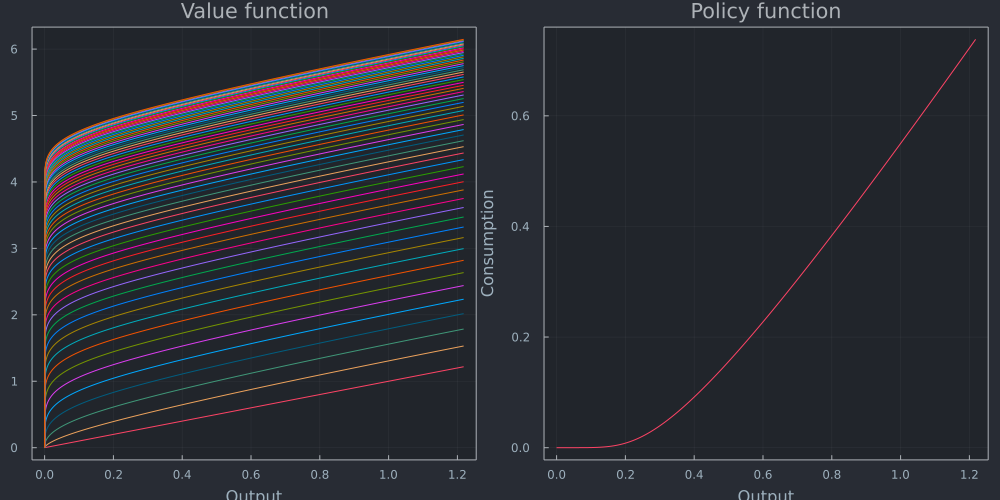

In [118]:
y_star =A^(1/(1-α)) * (β* α)^(α/(1-α))
plots = []
gr(fmt = :png, size = (1000, 500))
p1 = plot(range(0.0, y_star*2, N),V, title = "Value function", label=false,xlabel="Output")
push!(plots,p1)
p2 = plot(range(0.0, y_star*2, N),h[:,end], title = "Policy function", label=false,ylabel="Consumption",xlabel="Output")
push!(plots,p2)
plot(plots..., framestyle = :box)

Here we want to plot policy function (next perios's output) for each state (given output). We should consider that at each state we don't konw the next state, but we have a expextation of it.

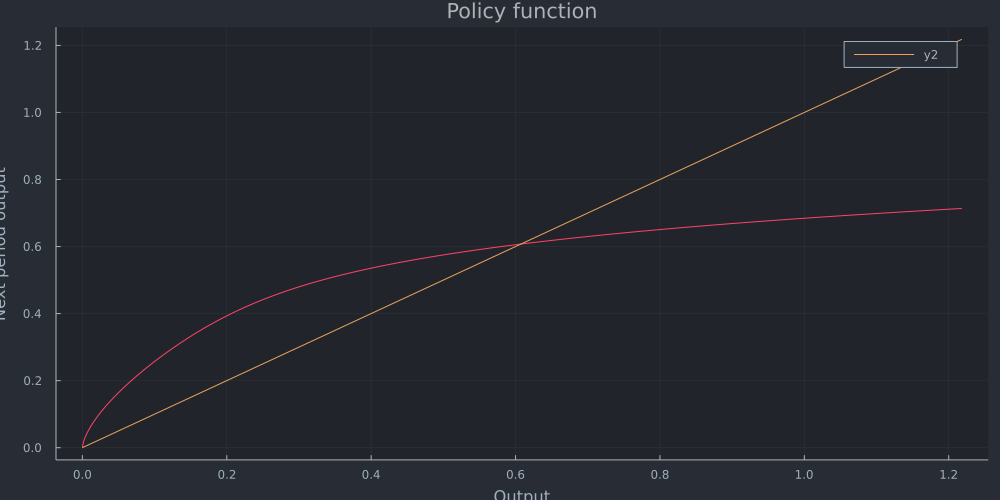

In [10]:
ygrid=range(0.0, y_star*2, N)
y′=A .*(ygrid .-h[:,end]) .^α
plot(range(0.0, y_star*2, N), y′, title = "Policy function", label=false,xlabel="Output",ylabel="Next period output")
plot!(ygrid,ygrid)

## 2 Policy function iteration

Bellman Equation with IID shock:
$$
V(x)=\max _{\{u\}}\{r(x, u)+\beta E[V(g(x, u, \xi)) \mid x]\}
$$
FOC:
$$
\frac{\partial r}{\partial u}(x, u)+\beta E\left[\frac{\partial g}{\partial u}(x, u, \xi) V^{\prime}(g(x, u, \xi)) \mid x\right]=0
$$
EC:
$$
V^{\prime}(x)=\frac{\partial r}{\partial x}(x, h(x))+\beta E\left[\frac{\partial g}{\partial x}(x, h(x), \xi) V^{\prime}(g(x, u, \xi)) \mid x\right]
$$
FOC for our problem and our notation:
$$
\frac{\partial U}{\partial c}(y, c)+\beta E\left[\frac{\partial f}{\partial c}(y, c, \xi) V^{\prime}(f(y, c, \xi)) \right]=0
$$
$$
\rightarrow c^{-\sigma} + \beta E[-\xi \alpha (y-c)^{\alpha -1} V^{\prime}(f(y, c, \xi)) ]=0
$$
And also we have:
$$
V^{\prime}(y)=\frac{\partial U}{\partial y}(y, h(y))+\beta E\left[\frac{\partial f}{\partial y}(y, h(y), \xi) V^{\prime}(f(y, c, \xi)) \right]
$$
$$
\rightarrow V^{\prime}(y)= \beta E[\xi \alpha (y-c)^{\alpha -1} V^{\prime}(f(y, c, \xi)) ]
$$

$$
\rightarrow V^{\prime}(y)= \beta E[\xi \alpha (y-c)^{\alpha -1} V^{\prime}(f(y, c, \xi)) ]
$$
$$
\rightarrow c^{-\sigma} + \beta E[-\xi \alpha (y-c)^{\alpha -1} V^{\prime}(f(y, c, \xi)) ]=0
$$

### Policy function iteration in y and c setting:

In [6]:
function PFI(r,g,shock_distribution,y_star,N,β,ϵ)
    Random.seed!(1394)
    ζ=rand(shock_distribution,N)
    A=mean(ζ)
    Initial(y)=y
    ygrid = range(0.0, y_star*2, N)
    ru(x,u)= x>=u ? Zygote.gradient(r,x,u)[2] : 0
    rx(x,u)= x>=u ? Zygote.gradient(r,x,u)[1] : 0
    gu(x,u,ζ)= x>=u ? Zygote.gradient(g,x,u,ζ)[2] : 0
    gx(x,u,ζ)= x>=u ? Zygote.gradient(g,x,u,ζ)[1] : 0
    h=zeros(N)
    V′ⱼ=Initial.(ygrid)
    dist = 1
    c_g=zeros(N)
    V′ⱼ₊₁=zeros(N)
    while ~(isapprox(dist, 0.0; atol=ϵ, rtol=0))
            V_intp = LinearInterpolation(ygrid, V′ⱼ,extrapolation_bc=Line())
            for i ∈ 2:N
                c=h[:,end][i]
                y=ygrid[i]
                if typeof(rx(y,c))!= Nothing
                    V′ⱼ₊₁[i]=rx(y,c) + β* mean(gx.(y,c,ζ) .* V_intp.(g.(y,c,ζ))) #EC
                else
                    V′ⱼ₊₁[i]= β* mean(gx.(y,c,ζ) .* V_intp.(g.(y,c,ζ)))
                end
            end
            V_intp_next = LinearInterpolation(ygrid, V′ⱼ₊₁,extrapolation_bc=Line())
            for i ∈ 2:N
                y=ygrid[i]
                G(c)=(ru(y,c) + β * mean( gu.(y,c,ζ) .* V_intp_next.( g.(y,c,ζ) )) )^2
                c_g[i] = optimize(G, 0.0, y).minimizer #FOC
            end
            dist = maximum(abs.(c_g .- h[:,end]))
            h=hcat(h,c_g)
            V′ⱼ=V′ⱼ₊₁
            c_g = zeros(N)
    end
    return h, LinearInterpolation(ygrid, h[:,end],extrapolation_bc=Line()), ygrid
end

PFI (generic function with 1 method)

In [21]:
y_star =A^(1/(1-α)) * (β* α)^(α/(1-α))
r(x,u)=(1/(1-σ))*(u^(1-σ))
g1(x,u,ζ)= ζ * (x-u)^α
h,c,ygrid=PFI(r,g1,LogNormal(0,ω),y_star,200,β,10^(-2))

([0.0 0.0 … 0.0 0.0; 0.0 0.0036903394583363194 … 2.5299793159944824e-12 8.151539742030036e-13; … ; 0.0 0.9433543413872238 … 0.6080915347465483 0.6049371616562262; 0.0 0.9482022142182203 … 0.6125097046403196 0.6093530330815682], 200-element extrapolate(scale(interpolate(::Vector{Float64}, BSpline(Linear())), (0.0:0.0050068694282561586:0.9963670162229755,)), Line()) with element type Float64:
 0.0
 8.151539742030036e-13
 1.4906463683571173e-10
 2.8462740414038903e-9
 2.189359380591535e-8
 1.0278887486774723e-7
 3.5426979586896126e-7
 9.883899132971507e-7
 2.3663220632649055e-6
 5.044824665456444e-6
 9.82336310449874e-6
 1.778173256251706e-5
 3.033615609673244e-5
 ⋮
 0.5609469795630064
 0.5653315583081323
 0.5697193998053676
 0.5741105113977116
 0.5785048927096671
 0.5829024632974826
 0.5873032797207776
 0.5917072592430807
 0.5961143130090043
 0.6005243093062862
 0.6049371616562262
 0.6093530330815682, 0.0:0.0050068694282561586:0.9963670162229755)

In [23]:
ygrid = collect(range(0.0, y_star *2, length = 200));
Initial(y)=y
y1=Initial.(ygrid);

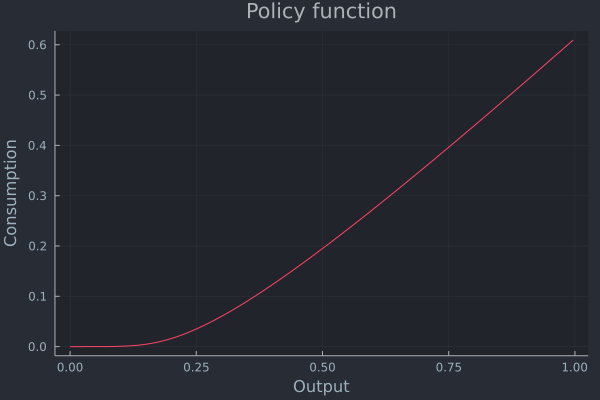

In [24]:
plot(y1,h[:,end], title = "Policy function", label=false,xlabel="Output",ylabel="Consumption")

## 3 Bellman solver

In [8]:
#the method is value function iteration
function Bellman_solver(r,h,method,shock_distribution,N,β,ϵ)
    Random.seed!(1394)
    ζ=rand(shock_distribution,N);
    A=mean(ζ)
#in steady state: h'(K)=1/β*A
    h′(x)= Zygote.gradient(h, x)[1]
    kbar(x)=(h′(x)-1/(β*A))^2
    K_bar= optimize( kbar, 0, 15).minimizer
    y_star =A*h(K_bar)
    ygrid = range(0.0, y_star*2, N)
    if method== "VFI"
        Initial_V(y)=y
        V₀ = Initial_V.(ygrid)
        Vⱼ = V₀
        Policy = zeros(N)
        Vⱼ₊₁ = zeros(N)
        g = zeros(N) 
        dist = 1
        while ~(isapprox(dist, 0.0; atol=ϵ, rtol=0))
            V = LinearInterpolation(ygrid, Vⱼ[:,end],extrapolation_bc=Line())
            for i ∈ 1:N
                Ω(c) = -(r(c) + β*mean(V.(ζ .* h(ygrid[i]-c))))
                opt = optimize(Ω, 0, ygrid[i])
                g[i] = opt.minimizer
                Vⱼ₊₁[i] = -Ω(g[i])
            end
            Policy = hcat(Policy,g)
            Vⱼ = hcat(Vⱼ,Vⱼ₊₁)
            dist = maximum(abs.(Vⱼ[:,end] .- Vⱼ[:,end-1]))
        end
    end
    return Vⱼ, Policy
end

Bellman_solver (generic function with 1 method)

In [12]:
U(c)=(c^(1-σ)) / (1-σ)
f(k)=A * (k)^α

f (generic function with 1 method)

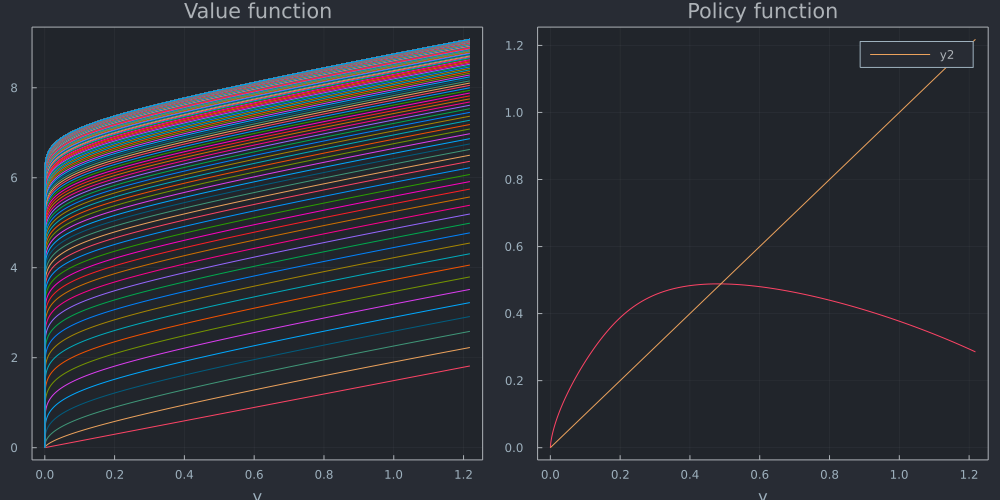

In [17]:
V, h = Bellman_solver(U,f,"VFI",LogNormal(0,ω),N,β,ϵ)
y_star =A^(1/(1-α)) * (β* α)^(α/(1-α))
plots = []
gr(fmt = :png, size = (1000, 500))
p1 = plot(range(0.0, y_star*2, N), V, title = "Value function", label=false,xlabel="y")
push!(plots,p1)
y′=A .*(ygrid .-h[:,end]) .^α
p2 = plot(range(0.0, y_star*2, N), y′, title = "Policy function", label=false,xlabel="y")
plot!(ygrid,ygrid)
push!(plots,p2)
plot(plots..., framestyle = :box)

# 2 Transitional Dynamics

## 1. Use your Value Function Iteration class written the previous problem sets and solve the following Bellman equation numerically:


In [23]:
function VFI_1(A,α,pₖ,δ,N,β,σ,ϵ)
    Initial_V(y)=y
    K_star= ((A*α)/(pₖ*(ρ+δ))).^(1/(1-α))
    kgrid = range(0.0, K_star*1.3, N)
    U(k,k′) = (1/(1-σ)) * (A*k^α +(1-δ)*k -k′)^(1-σ)
    Γ(K) = (A*(K)^α)/pₖ + (1-δ)*K
    V₀ = Initial_V.(kgrid)
    Vⱼ = V₀
    h = zeros(N)
    Vⱼ₊₁ = zeros(N)
    g = zeros(N) 
    dist = 1
    while ~(isapprox(dist, 0.0; atol=ϵ, rtol=0))
        V = LinearInterpolation(kgrid, Vⱼ[:,end],extrapolation_bc=Line())
        for i ∈ 1:N
            k=kgrid[i]
            Ω(k′) = -(U(k,k′) + β*V(k′))
            opt = optimize(Ω, 0,Γ(kgrid[i]))
            g[i] = opt.minimizer
            Vⱼ₊₁[i] = -Ω(g[i])
        end
        h = hcat(h,g)
        Vⱼ = hcat(Vⱼ,Vⱼ₊₁)
        dist = maximum(abs.(Vⱼ[:,end] .- Vⱼ[:,end-1]))
    end
    return Vⱼ, h
end

VFI_1 (generic function with 1 method)

In [24]:
A,α,pₖ,δ,N,β,σ,ϵ=1,0.65,1,0.5,100,0.95,0.1,10^(-2)
ρ=1/β -1
V , h=VFI_1(A,α,pₖ,δ,N,β,σ,ϵ)

([0.0 0.0 … 0.0 0.0; 0.020877230989475047 0.12888964402867664 … 9.850315137659111 9.860265027419242; … ; 2.0459686369685546 2.6610241890202255 … 13.406871900869643 13.416821790629742; 2.0668458679580297 2.6809575248047266 … 13.428233913013642 13.438183802773777], [0.0 0.0 … 0.0 0.0; 0.0 3.394584980787614e-16 … 0.09130834121248727 0.09130834121281191; … ; 0.0 0.9453197007366605 … 1.7804906047752693 1.7804906314614513; 0.0 0.9663021497540724 … 1.7954418440287117 1.7954418440299327])

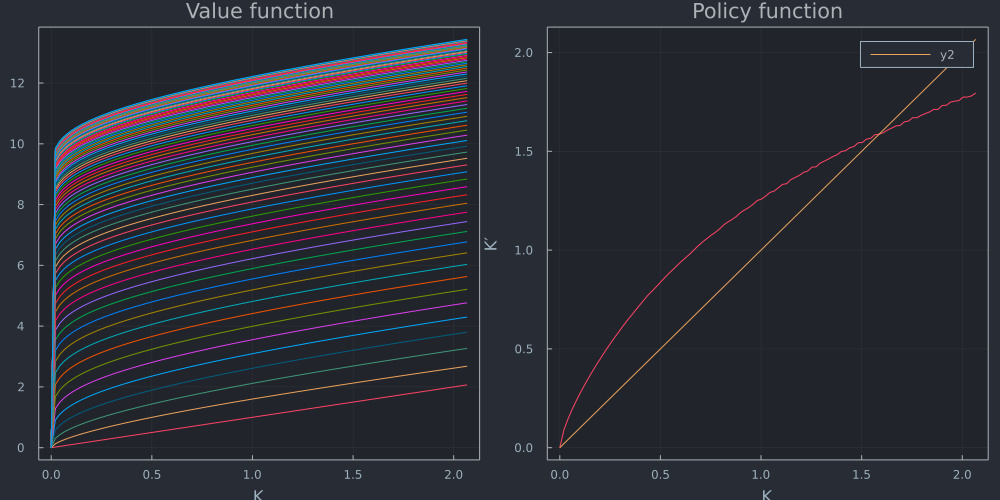

In [26]:
K_star= ((A*α)/(pₖ*(ρ+δ))).^(1/(1-α))
kgrid = range(0.0, K_star*1.3, N)
plots = []
gr(fmt = :png, size = (1000, 500))
p1 = plot(range(0.0, K_star*1.3, N),V, title = "Value function", label=false,xlabel="K")
push!(plots,p1)
p2 = plot(range(0.0, K_star*1.3, N),h[:,end], title = "Policy function", label=false,ylabel="K′",xlabel="K")
plot!(range(0.0, K_star*1.3, N),range(0.0, K_star*1.3, N))
push!(plots,p2)
plot(plots..., framestyle = :box)

## 2. Write a function to calculate the half-life time (the number of periods that it takes to reach to half of the distance to the steady state. Plot the Half-Life values for k0 2 (0; kss)


In [31]:
V1 = LinearInterpolation(kgrid, V[:,end],extrapolation_bc=Line())
h1 = LinearInterpolation(kgrid, h[:,end],extrapolation_bc=Line());

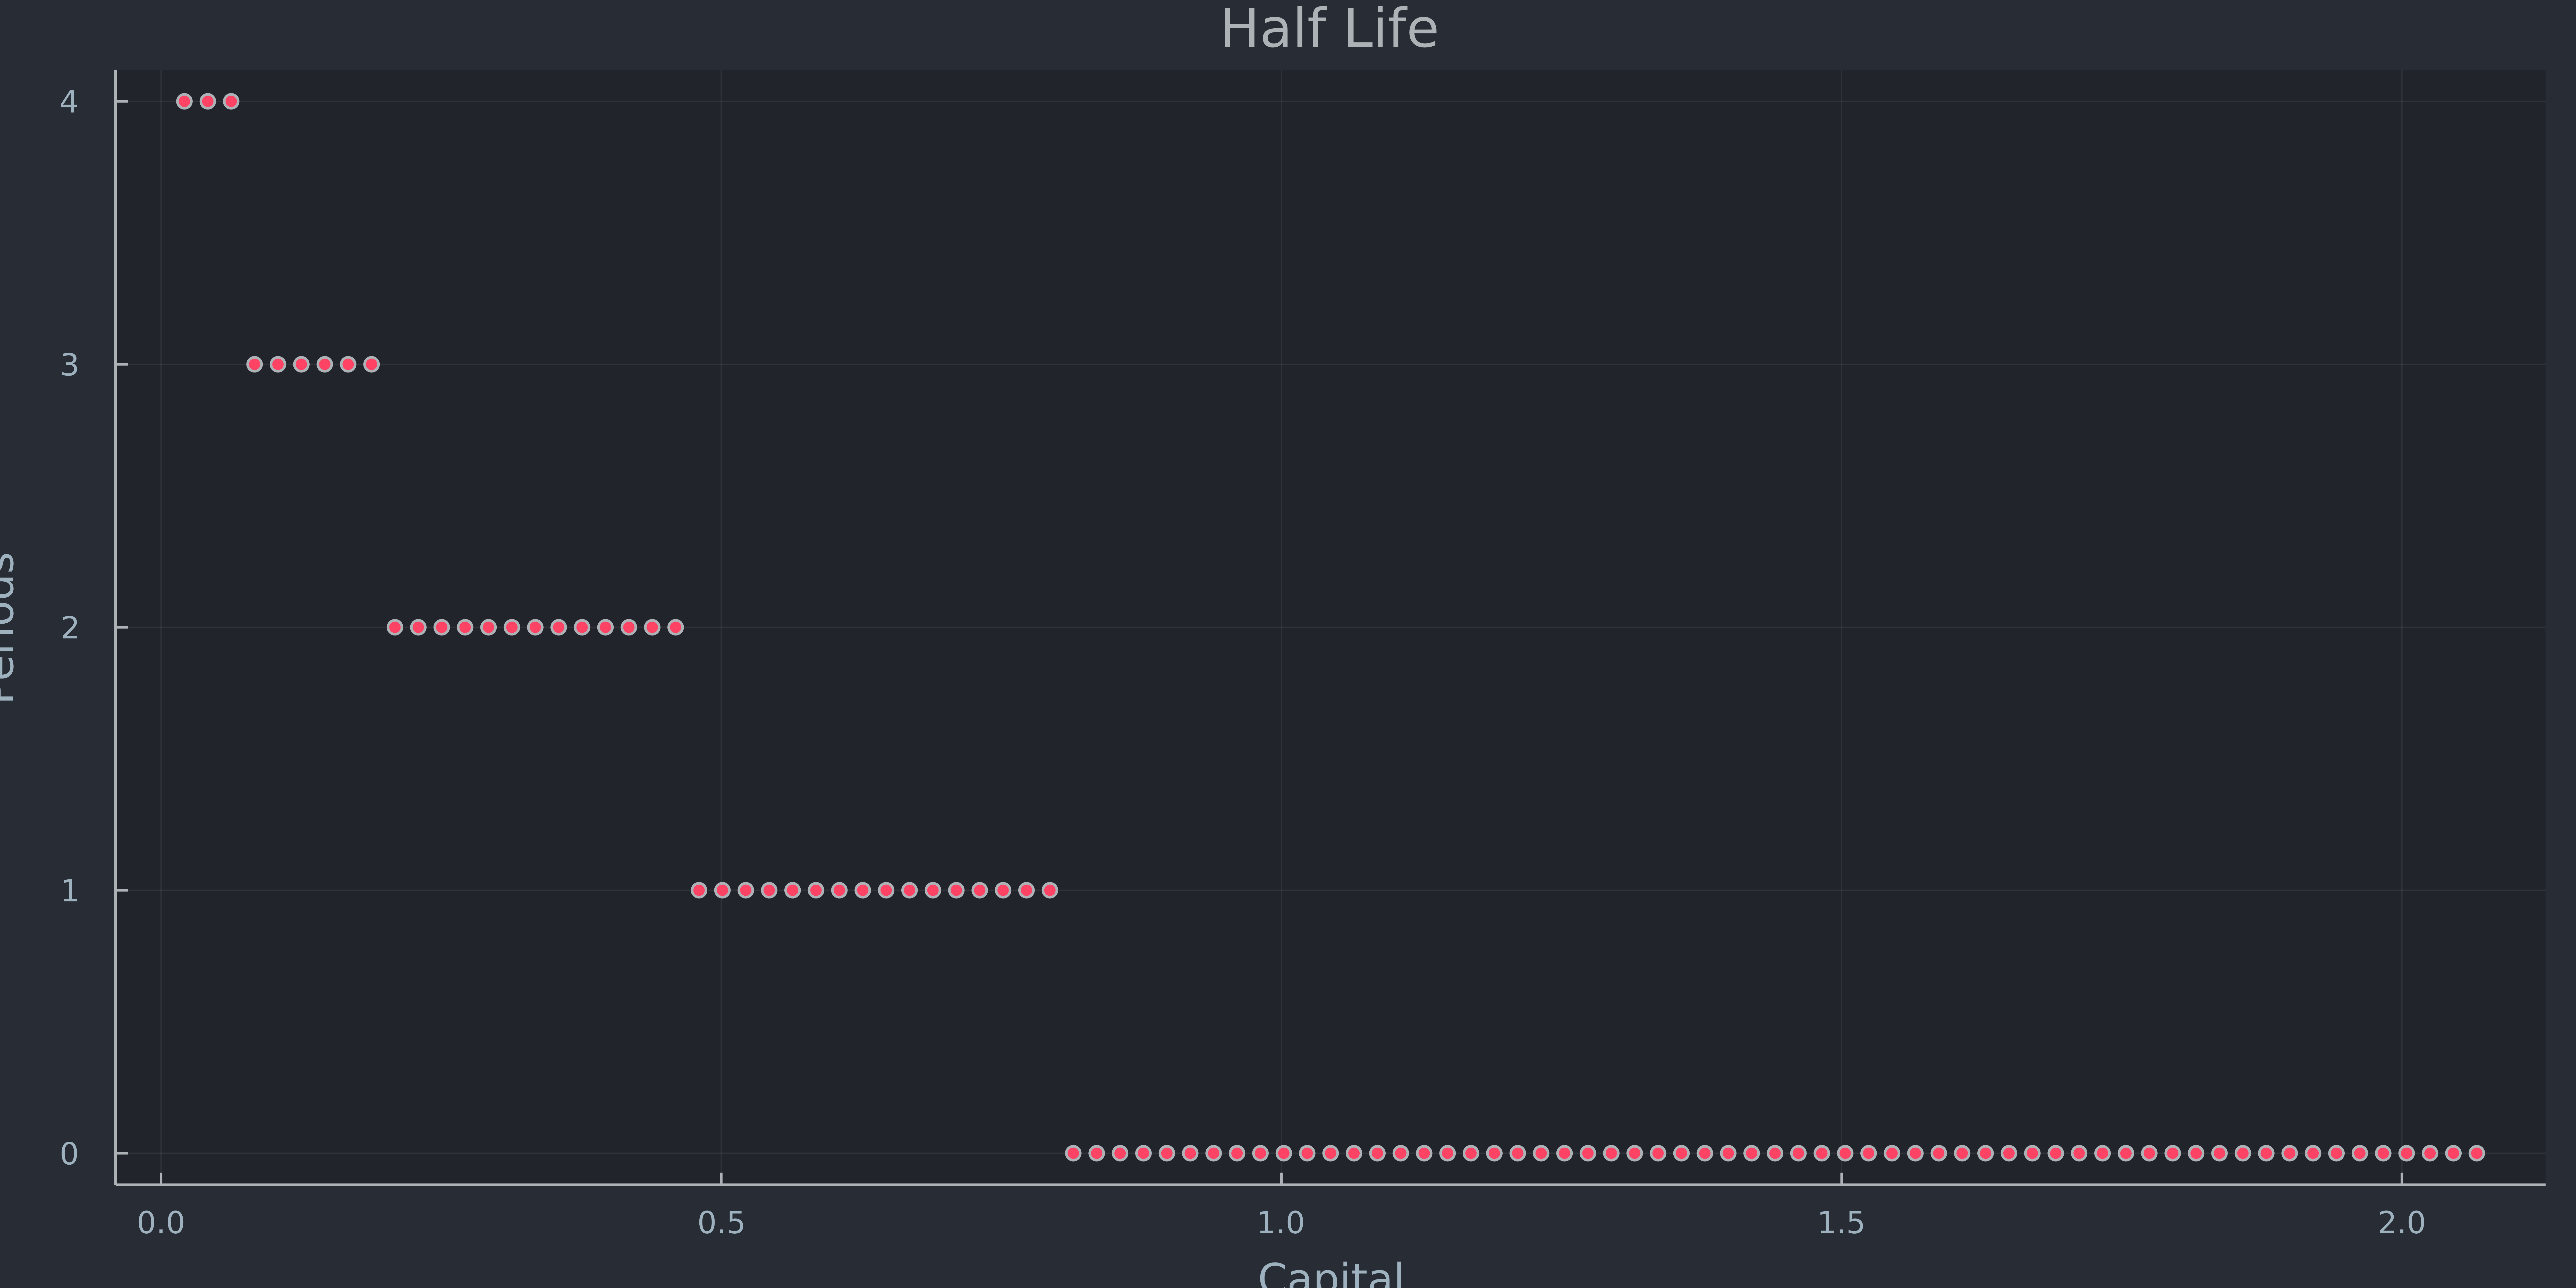

In [35]:
Halflife(k) = k >= K_star/2 ? 0 : 1 + Halflife(h1(k))
scatter(Halflife, kgrid[2:end], legend = false, title = "Half Life", xlabel = "Capital", ylabel = "Periods", markersize = 3, yticks = 0:1:13, dpi = 1000)    

## 3. Write a function to calculate the number of periods that it takes to reach to 1% distance of the steady state. Plot the results for k0 2 (0; kss).

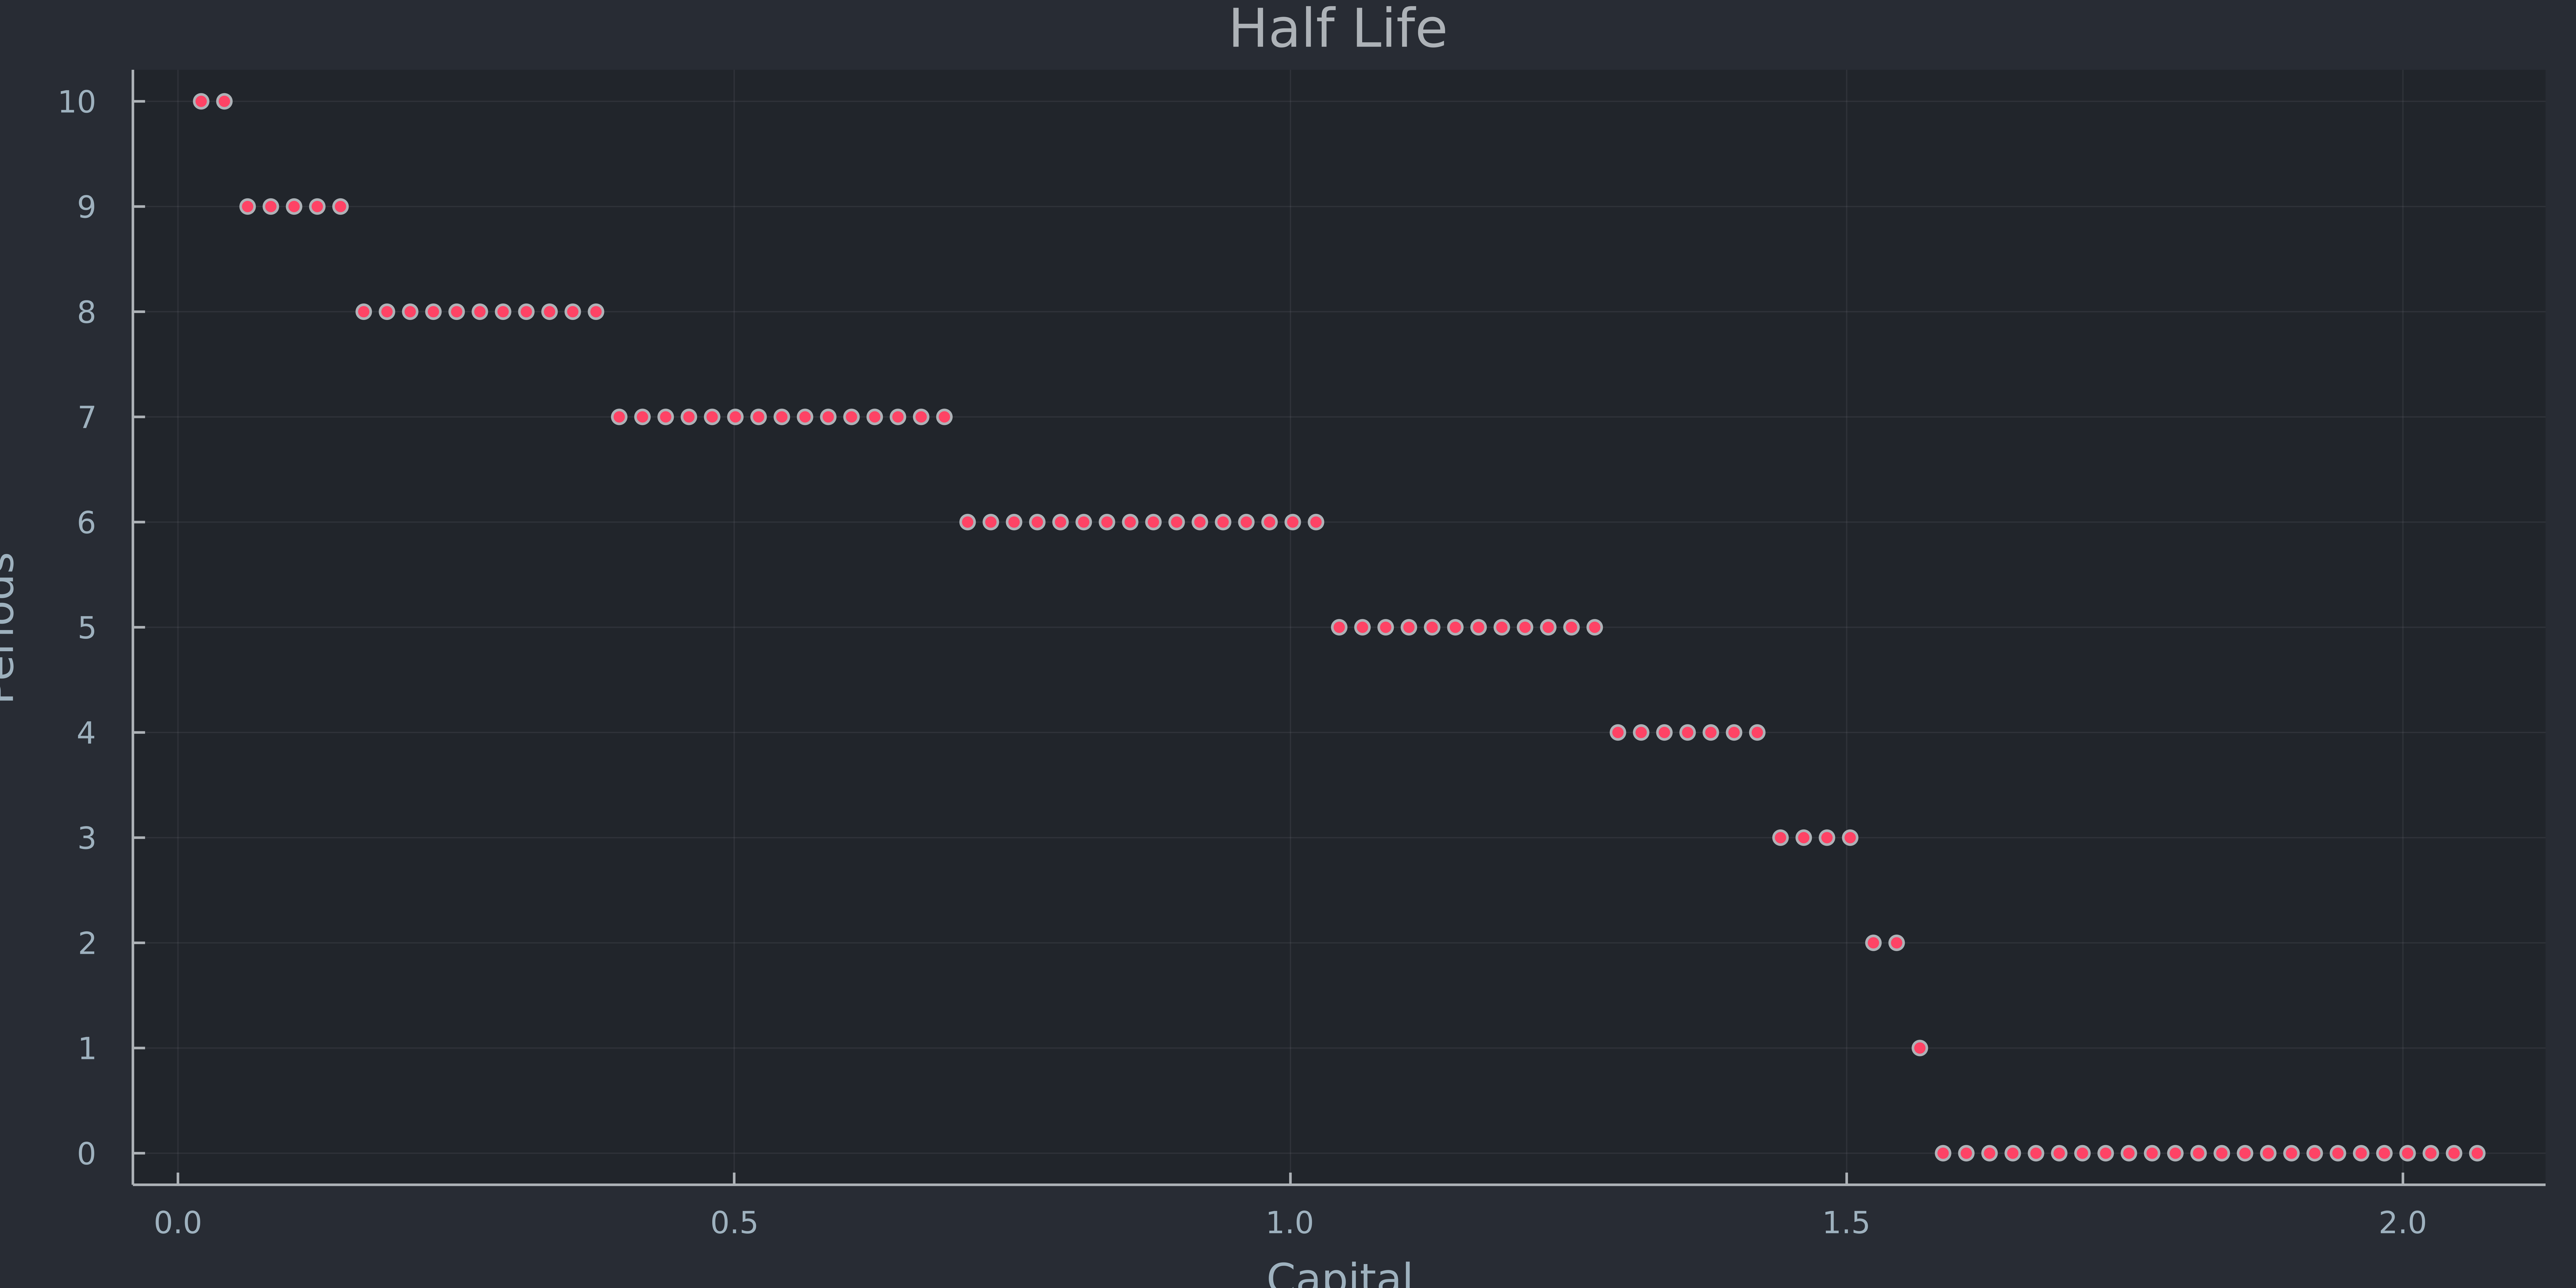

In [34]:
Halflife(k) = k >= 0.99 *K_star ? 0 : 1 + Halflife(h1(k))
scatter(Halflife, kgrid[2:end], legend = false, title = "Half Life", xlabel = "Capital", ylabel = "Periods", markersize = 3, yticks = 0:1:13, dpi = 1000)    

# 3 Log-Linearization Method

# 4 Discrete Dynamic Programming